## full version, counting and estimate frequency for all arriving elements## Count

- Tpo 512+ CMS 128*256

        Total memory 266928 bytes :Top-512 with size 4720 bytes+ CMS with size 262208 bytes.
        Execution time:2233.846 seconds.
        Precision: 0.619140625
        Top_ARE: 22.217085
        Top_AAE: 1365140.000
        all_ARE: 2564.406865
        all_AAE: 2667.459
        Estimate time: 659.030 seconds.

EOF
Execution time: 749.395 seconds.
Top-1024 in CMS-112*192
Precision:  0.376
Top_dict with 36968 bytes.
CMS Sketch with 86128 bytes.
Total size 123096 bytes, 
Find:385
Top_ARE: 32.9501
Top_AAE: 3623.1013
Estimate time:  1.385 seconds.


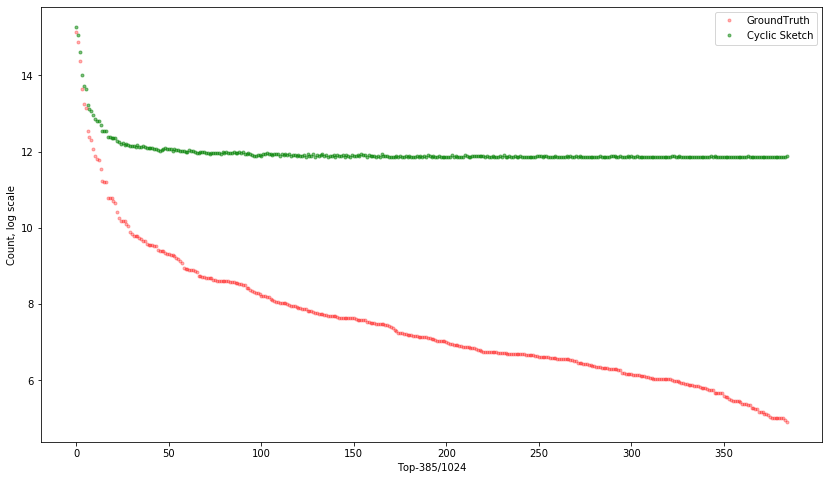

In [5]:
# ver 20210829, rewrite

import sys
import os
import time
import pandas as pd
from Node import DS
from Tools import Func
from Tools import Config
import numpy as np
import operator
import mmh3

def position(element,index):
    hash1=mmh3.hash(element.ID,seed=Config.seed[index], signed=False)
    pos=hash1 % Config.width
    return pos 

def Add_CMS(element,sketch):
    index_li=[0 for _ in range(Config.depth)]
    for row in range(Config.depth):
        col=position(element,row)
        index_li[row]=col
        sketch[row][col]+=1
    #print("index_li in add CMS:{}".format(index_li))
    #print("len(index_li)={}".format(len(index_li)))
    return index_li

def Estimate_CMS(element,sketch,index_li):
    '''
    countlist=[]
    for row in range(Config.depth):
        col=position(element,row)
        countlist.append(sketch[row][col])    
    '''
    return min([sketch[i][index_li[i]] for i in range(len(index_li))])
        

filename='kosarak.dat'
filepath=r"..\dataset\kosarak"
gr_file_name='kosarak_ground_truth.csv'
src_data=os.path.join(filepath,filename)
    # dataset
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth
    
w=192
d=112
size=1024
topk=1024
Config.Set_default(w,d,size,topk)
    # set width, depth, size of Sk, random seed of hash
    # Config.width, Config.depth
    # return width,depth,size,seed,topk
Sketch=np.zeros((Config.depth,Config.width),dtype='int32')
Top_dict=dict()

#item_count=100
start=time.time()
with open(src_data,'r') as file:
    while True:
        e=file.readline().strip('\n')
        if not e:
            print('EOF')
            break
        else:
            #item_count-=1
            item=DS.Tail(e,1)
            position_li=Add_CMS(item,Sketch)
            #print(len(position_li))
            count=Estimate_CMS(item,Sketch,position_li)
            if len(Top_dict)<Config.size:
                Top_dict[item.ID]=count
            else:
                if Top_dict.get(item.ID):
                    # e in Top
                    Top_dict[item.ID]=count
                else:
                    min_ele = min(Top_dict, key=Top_dict.get)
                        # find e_min
                    if count >Top_dict[min_ele]:
                        Top_dict[item.ID]=count
                        Top_dict.pop(min_ele)
            #print("position_li:{}".format(position_li))
            #print("count={}".format(count))                        
            #print("sketch:{}".format(Sketch))
end=time.time()
Top_dict=dict(sorted(Top_dict.items(), key=lambda item: item[1],reverse=True))
print("Execution time:{:8.3f} seconds.".format(end-start))
   
# Element-Precision
# keep tracking top-1024 all the time
tp_set,precision=Func.Get_precision(gr_path,Top_dict,Config.topk)
print("Top-{} in CMS-{}*{}".format(Config.topk,Config.depth,Config.width))
print("Precision: {:6.3f}".format(precision))

# Count-Precision
# compare estimation count with ground truth.

# memory usage
print("Top_dict with {} bytes.".format(sys.getsizeof(Top_dict)))
print("CMS Sketch with {} bytes.".format(sys.getsizeof(Sketch)))
print("Total size {} bytes, ".format(sys.getsizeof(Top_dict)+sys.getsizeof(Sketch)))

# Count ARE/AAE
startx=time.time()
top_are,top_aae=Func.Get_ARE_AAE(gr_path,Top_dict,tp_set)
print("Find:{}".format(len(tp_set)))
#print("{} item found in SS[{}] compare with true Top-{}".format(len(tp_set),Config.size,topk))
endx=time.time()

print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

Func.Plot_topk_compare(gr_path,Top_dict)

In [ ]:
# Count-Min sketch with built-in index search

import sys
import os
import time
from probables import (CountMinSketch)
import pandas as pd
from Node import DS
from Tools import Func
from Tools import Config


filename='kosarak.dat'
filepath=r"..\dataset\kosarak"
gr_file_name='kosarak_ground_truth.csv'
src_data=os.path.join(filepath,filename)
    # dataset
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth
    
w=128
d=128
size=1024
topk=1024
Config.Set_default(w,d,size,topk)
    # set width, depth, size of Sk, random seed of hash
    # Config.width, Config.depth
    
Top_dict=dict()
cms = CountMinSketch(width=Config.width, depth=Config.depth)
e_min=DS.Tail("",1)


item_count=10000
start=time.time()
with open(src_data,'r') as file:
    while True:
        e=file.readline().strip('\n')
        if not e:
            print('EOF')
            break
        else:
            #item_count-=1
            #print("read {}th element: {}".format(item_count,line[:10]))
            item=DS.Tail(e,1)
            cms.add(item.ID)
            count=cms.check(item.ID)
            if Top_dict.get(item.ID):
                # e in Top
                Top_dict[item.ID]=count
            else:
                # e not in Top
                if len(Top_dict)<Config.size:
                    # Top is not full
                    Top_dict[item.ID]=count
                else:
                    min_ele = min(Top_dict, key=Top_dict.get)
                        # find e_min
                    if count >Top_dict[min_ele]:
                        Top_dict[item.ID]=count
                        # update c_min
                        Top_dict.pop(min_ele)
                        # pop old min out
end=time.time()
Top_dict=dict(sorted(Top_dict.items(), key=lambda item: item[1],reverse=True))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Element-Precision
tp_set,precision=Func.Get_precision(gr_path,Top_dict,Config.topk)
print("Top-{} in CMS-{}*{}:".format(Config.topk,Config.width,Config.depth))
print("Precision: {:6.3f}".format(precision))

# memory usage
print("Top_dict with {} bytes.".format(sys.getsizeof(Top_dict)))
print("CMS Sketch with {} bytes.".format(sys.getsizeof(cms._bins)))
print("Total size {} bytes, ".format(sys.getsizeof(Top_dict)+sys.getsizeof(cms._bins)))


In [ ]:
x=[0]
x

In [ ]:
# Count-Min sketch with built-in index search

import sys
import os
import time
from probables import (CountMinSketch)
import pandas as pd

def find(e,element_list):
    # return index of e in element_list
    try:
        index=[ele[0] for ele in element_list].index(e)
    except:
        index=-99
    return index

#====================main=============================
filename='kosarak.dat'
filepath='..\\dataset\\kosarak'
src_data=os.path.join(filepath,filename)
Top=[]
w=256
d=128
size=1024
# item_count=10000
cms = CountMinSketch(width=w, depth=d)

start=time.time()
if os.path.exists(src_data):
    with open(src_data,'r') as file:
        while True:
            line=file.readline().strip('\n')
            if not line:
                print('EOF')
                break
            else:
                #item_count-=1
                #print("read {}th element: {}".format(item_count,line[:10]))
                cms.add(line)
                count=cms.check(line)
                index=find(line,Top)
                if index >=0:
                    Top[index][1]=count
                else:
                    # e not in Top
                    if len(Top)<size:
                        # Top is not full
                        Top.append([line,count])
                        index=len(Top)-1
                        #print("id of iindex:{}".format(id(index)))
                    else:
                        # Top if full
                        if count< Top[-1][1]:
                            pass
                        else:
                            Top.append([line,count])
                if len(Top)<=size:
                    if index==0 or Top[index][1]<Top[index-1][1]:
                        pass
                    else:
                        Top=sorted(Top,key = lambda Top:Top[1],reverse=True)
                else:
                    Top=sorted(Top,key = lambda Top:Top[1],reverse=True)
                    Top.pop()
                #rint("Top after insert:{}\n".format(Top))                    
    #print(topk[:20],len(topk))
else:
    print("file doesn't exist")
end=time.time()
print("Total memory {3} bytes :Top-{0} with size {1} bytes+ CMS with size {2} bytes.".format(len(Top),sys.getsizeof(Top),
      sys.getsizeof(cms._bins),sys.getsizeof(cms._bins)+sys.getsizeof(Top)))
print("Execution time:{:8.3f} seconds.".format(end-start)) 
#====================Top to csv=============================
templi=[[i[0],i[1]] for i in Top]

df=pd.DataFrame(templi,columns=['ID', 'Count'])
name="CMS_kosarak_Top-"+str(size)+'_'+str(d)+'_'+str(w)+'.csv'
df.to_csv(os.path.join('result',name),index=False)    

# ====================precision====================
# path="..\\Caida0\\"
gr_path='..\\dataset\\kosarak'
gr_file_name='kosarak_ground_truth.csv'
grtruth=pd.read_csv(os.path.join(gr_path,gr_file_name))
    # compare with Top-k and groundtruth[k]
CMS_result=pd.read_csv(os.path.join('result',name))

# precision
gt_set=set(grtruth['Element'][:size])
cms_set=set(CMS_result['ID'])
precision=len(gt_set & cms_set)/len(cms_set)
    # &: set 交集運算
    # precision= tp/tp+fp=tp/size
print("Precision: {}".format(precision))


# ====================ARE/AAE for all====================
gt_dict=dict(grtruth.values.tolist())
top_are=0
top_aae=0
all_are=0
all_aae=0

read=0

startx=time.time()
for item in grtruth['Element']:
    count=cms.check(str(item))    
    if read<size:
        top_are+=abs(count-gt_dict[item])/gt_dict[item]
        top_aae+=abs(count-gt_dict[item])
        read+=1
    all_are+=abs(count-gt_dict[item])/gt_dict[item]
    all_aae+=abs(count-gt_dict[item])
endx=time.time()

distinct=len(gt_dict)
top_are/=size
all_are/=distinct
all_aae/=distinct 
print("Top_ARE: {:8.6f}".format(top_are))
print("Top_AAE: {:8.3f}".format(top_aae))
print("all_ARE: {:8.6f}".format(all_are))
print("all_AAE: {:8.3f}".format(all_aae))
print("Estimate time:{:8.3f} seconds.".format(endx-startx))

## count完再和Ground truth比較

In [ ]:
import sys
import os
import time
from probables import (CountMinSketch)
import pandas as pd
import re

def find(e,element_list):
    # return index of e in element_list
    try:
        index=[ele[0] for ele in element_list].index(e)
    except:
        index=-99
    return index

#====================main=============================

filename='kosarak.dat'
filepath="..\\dataset\\kosarak"
src_data=os.path.join(filepath,filename)
Top=[]
w=1024
d=8
size=512
# item_count=10000
cms = CountMinSketch(width=w, depth=d)

start=time.time()
with open(src_data,'r') as file:
    while True:
        e=file.readline().strip('\n')
        if not e:
            print('EOF')
            break
        else:
            #item_count-=1
            #print("read {}th element: {}".format(item_count,e))
            cms.add(str(e))
            '''
            count=cms.check(line)
            index=find(line,Top)
            if index >=0:
                Top[index][1]=count
            else:
                # e not in Top
                if len(Top)<size:
                    # Top is not full
                    Top.append([line,count])
                    index=len(Top)-1
                    #print("id of iindex:{}".format(id(index)))
                else:
                    # Top if full
                    if count< Top[-1][1]:
                        pass
                    else:
                        Top.append([line,count])
                        Top=sorted(Top,key = lambda Top:Top[1],reverse=True)
                        Top.pop()
                        #rint("Top after pop:{}\n".format(Top))
            Top=sorted(Top,key = lambda Top:Top[1],reverse=True)
            #print("Top after insert:{}\n".format(Top))
            '''  
end=time.time()
#print(topk[:20],len(topk))
print("Total memory {3} bytes :Top-{0} with size {1} bytes+ CMS with size {2} bytes.".format(len(Top),sys.getsizeof(Top),
      sys.getsizeof(cms._bins),sys.getsizeof(cms._bins)+sys.getsizeof(Top)))
print("Execution time:{} seconds.".format(str(end-start)))


#====================Top to csv=============================
'''
templi=[[i[0],i[1]] for i in Top]
df=pd.DataFrame(templi,columns=['ID', 'Count'])
name="CMS_kosarak_Top-"+str(size)+'_'+str(d)+'_'+str(w)+'.csv'
df.to_csv(os.path.join('result',name),index=False)
'''

# path='..\\kosarak'
gr_path='..\\dataset\\kosarak'
gr_file_name='kosarak_ground_truth.csv'
#final="CM_kosarak_"+str(size)+".csv"
grtruth=pd.read_csv(os.path.join(gr_path,gr_file_name))
gt_dict=dict(grtruth.values.tolist())
top_are=0
top_aae=0
all_are=0
all_aae=0

read=0

startx=time.time()
for item in grtruth['Element']:
    count=cms.check(str(item))    
    if read<size:
        top_are+=abs(count-gt_dict[item])/gt_dict[item]
        top_aae+=abs(count-gt_dict[item])
        read+=1
    all_are+=abs(count-gt_dict[item])/gt_dict[item]
    all_aae+=abs(count-gt_dict[item])
endx=time.time() 
distinct=len(grtruth)
top_are/=size
all_are/=distinct
all_aae/=distinct 
print("Execution time:{:8.3f} seconds.".format(endx-startx))  
print("Top_ARE: {:8.6f}".format(top_are))
print("Top_AAE: {:8.3f}".format(top_aae))
print("all_ARE: {:8.6f}".format(all_are))
print("all_AAE: {:8.3f}".format(all_aae))
